In [ ]:
!pip install --upgrade --force-reinstall transformers==4.39.3

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.8/134.8 kB 5.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.0/62.0 kB 5.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 40.5/40.5 kB 1.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 57.7/57.7 kB 5.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 8.8/8.8 MB 102.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 509.3/509.3 kB 44.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 16.8/16.8 MB 42.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 66.5/66.5 kB 7.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 763.0/763.0 kB 51.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 792.7/792.7 kB 54.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 471.6/471.6 kB 32.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.6/3.6 MB 109.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━

In [ ]:
!wget  -O 'spamdata_v2.csv' -q 'https://www.dropbox.com/scl/fi/awvbofou09yuomcywua97/spamdata_v2.csv?rlkey=xuamzpesiye6xl5ey3nh65v4c&dl=0'

In [ ]:
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
from torch.utils.data import TensorDataset, DataLoader, RandomSampler, SequentialSampler
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report
import transformers
from transformers import AutoModel, BertTokenizerFast, AdamW
import re
import string
import nltk

nltk.download('stopwords')
nltk.download('wordnet')

# выбор устройства GPU
device = torch.device("cuda")

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


In [ ]:
df = pd.read_csv("spamdata_v2.csv")
df.head()

,label,text
0,0,"Go until jurong point, crazy.. Available only ..."
1,0,Ok lar... Joking wif u oni...
2,1,Free entry in 2 a wkly comp to win FA Cup fina...
3,0,U dun say so early hor... U c already then say...
4,0,"Nah I don't think he goes to usf, he lives aro..."


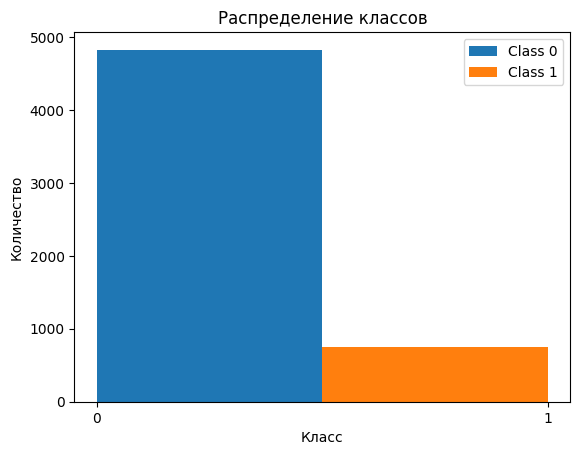

label
0    4825
1     747
Name: count, dtype: int64


In [ ]:
plt.hist(df.loc[df['label'] == 0]['label'], bins = 2, range = (0, 1), label = 'Class 0')
plt.hist(df.loc[df['label'] == 1]['label'], bins = 2, range = (0, 1), label = 'Class 1')
plt.xticks([0, 1], ['0', '1'])
plt.legend()
plt.xlabel('Класс')
plt.ylabel('Количество')
plt.title('Распределение классов')
plt.show()

print(df['label'].value_counts())

In [ ]:
stopword = nltk.corpus.stopwords.words('english')
ps = nltk.PorterStemmer()
wn = nltk.WordNetLemmatizer()

def cleaning(text):
    text_nopunct = ''.join([char for char in text if char not in string.punctuation])
    tokens = re.split('\W+', text_nopunct)
    stopwords = [word for word in tokens if word not in stopword]
    stemming = [ps.stem(word) for word in stopwords]
    lemmatizing = [wn.lemmatize(word) for word in stemming]
    return lemmatizing

df['cleaned_text'] = df['text'].apply(lambda x: cleaning(x))
df.head()

,label,text,cleaned_text
0,0,"Go until jurong point, crazy.. Available only ...","[go, jurong, point, crazi, avail, bugi, n, gre..."
1,0,Ok lar... Joking wif u oni...,"[ok, lar, joke, wif, u, oni]"
2,1,Free entry in 2 a wkly comp to win FA Cup fina...,"[free, entri, 2, wkli, comp, win, fa, cup, fin..."
3,0,U dun say so early hor... U c already then say...,"[u, dun, say, earli, hor, u, c, alreadi, say]"
4,0,"Nah I don't think he goes to usf, he lives aro...","[nah, i, dont, think, goe, usf, live, around, ..."


In [ ]:
train_text, temp_text, train_label, temp_label = train_test_split(df['cleaned_text'], df['label'], test_size = 0.3, random_state = 2018, stratify = df['label'])
val_text, test_text, val_label, test_label = train_test_split(temp_text, temp_label, test_size = 0.5, random_state = 2018, stratify = temp_label)

In [ ]:
# BERT-base pretrained model
bert = AutoModel.from_pretrained('bert-base-uncased')

# BERT tokenizer
tokenizer = BertTokenizerFast.from_pretrained('bert-base-uncased')

/usr/local/lib/python3.11/dist-packages/huggingface_hub/file_download.py:943: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


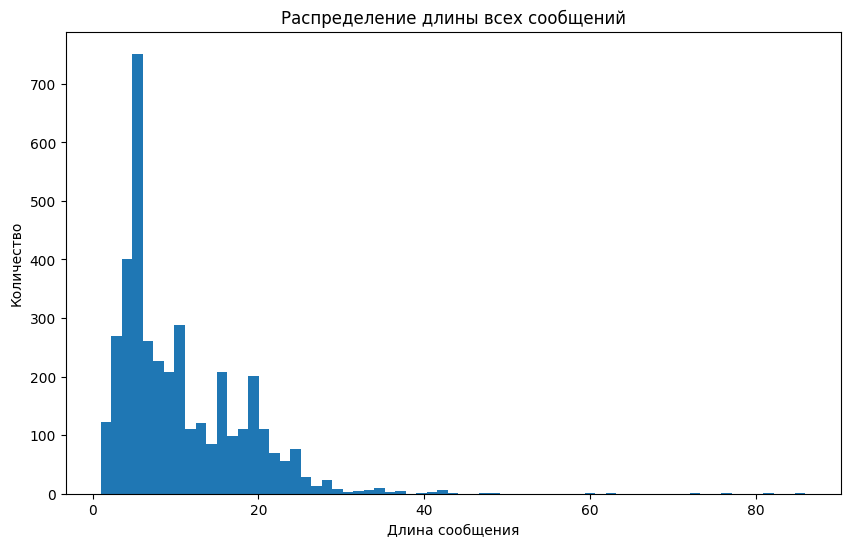

Максимальная длина входной последовательности = 86


In [ ]:
message_lengths = []
for message in train_text:
    message_len = len(message)
    message_lengths.append(message_len)

plt.figure(figsize = (10,6))
plt.hist(message_lengths, bins = 'auto')
plt.xlabel('Длина сообщения')
plt.ylabel('Количество')
plt.title('Распределение длины всех сообщений')
plt.show()

print(f"Максимальная длина входной последовательности = {max(message_lengths)}")

In [ ]:
# tokenize and encode sequences in the training set
tokens_train = tokenizer(
    train_text.to_list(),
    is_split_into_words=True,
    max_length = 40,
    padding='max_length',
    truncation = True
)

# tokenize and encode sequences in the validation set
tokens_val = tokenizer(
    val_text.to_list(),
    is_split_into_words=True,
    max_length = 40,
    padding='max_length',
    truncation = True
)

# tokenize and encode sequences in the test set
tokens_test = tokenizer(
    test_text.to_list(),
    is_split_into_words=True,
    max_length = 40,
    padding='max_length',
    truncation = True
)

In [ ]:
## convert lists to tensors

train_seq = torch.tensor(tokens_train['input_ids'])
train_mask = torch.tensor(tokens_train['attention_mask'])
train_y = torch.tensor(train_label.to_list())

val_seq = torch.tensor(tokens_val['input_ids'])
val_mask = torch.tensor(tokens_val['attention_mask'])
val_y = torch.tensor(val_label.to_list())

test_seq = torch.tensor(tokens_test['input_ids'])
test_mask = torch.tensor(tokens_test['attention_mask'])
test_y = torch.tensor(test_label.to_list())

In [ ]:
batch_size = 10

train_data = TensorDataset(train_seq, train_mask, train_y)
train_sampler = RandomSampler(train_data)
train_dataloader = DataLoader(train_data, sampler = train_sampler, batch_size = batch_size)

val_data = TensorDataset(val_seq, val_mask, val_y)
val_sampler = RandomSampler(val_data)
val_dataloader = DataLoader(val_data, sampler = val_sampler, batch_size = batch_size)

In [ ]:
for param in bert.parameters():
    param.requires_grad = False

In [ ]:
class BERT_Arch(nn.Module):
    def __init__(self, bert):
        super(BERT_Arch, self).__init__()

        self.bert = bert
        # dropout layer
        self.dropout = nn.Dropout(0.1)
        # relu activation function
        self.relu = nn.ReLU()
        # dense layer 1
        self.fc1 = nn.Linear(768, 512)
        # dense layer 2 (Output layer)
        self.fc2 = nn.Linear(512, 2)
        #softmax activation function
        self.softmax = nn.LogSoftmax(dim = 1)

    #define the forward pass
    def forward(self, sent_id, mask):
        #pass the inputs to the model
        _, cls_hs = self.bert(sent_id, attention_mask = mask,  return_dict=False)

        x = self.fc1(cls_hs)

        x = self.relu(x)

        x = self.dropout(x)
        # output layer
        x = self.fc2(x)
        # apply softmax activation
        x = self.softmax(x)

        return x

In [ ]:
# применяем исходную модель к нашей измененной
model = BERT_Arch(bert)
# Перенесите модель на GPU
model = model.to(device)

In [ ]:
# Настройка оптимизатора
optimizer = AdamW(model.parameters(), lr = 5e-5)

/usr/local/lib/python3.11/dist-packages/transformers/optimization.py:457: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


In [ ]:
from sklearn.utils.class_weight import compute_class_weight

# Вычисление веса класса для учета дисбаланса
class_weights = compute_class_weight(class_weight = 'balanced',
                                     classes = np.unique(train_label),
                                     y = train_label)

In [ ]:
# преобразование списка весов классов в тензор
weights = torch.tensor(class_weights, dtype = torch.float)

# перенос на GPU
weights = weights.to(device)

# Определение функции потерь
cross_entropy = nn.NLLLoss(weight = weights)

# Задайте число эпох
epochs = 20

In [ ]:
# Функция для обучения модели
def train():

    model.train()
    total_loss, total_accuracy = 0, 0

    # empty list to save model predictions
    total_preds = []

    for step, batch in enumerate(train_dataloader):

        # progress update after every 50 batches.
        if step % 50 == 0 and not step == 0:
            print('  Batch {:>5,}  of  {:>5,}.'.format(step, len(train_dataloader)))

        # push the batch to gpu
        batch = [r.to(device) for r in batch]

        sent_id, mask, labels = batch

        # clear previously calculated gradients
        model.zero_grad()

        # get model predictions for the current batch
        preds = model(sent_id, mask)

        # compute the loss between actual and predicted values
        loss = cross_entropy(preds, labels)

        # add on to the total loss
        total_loss = total_loss + loss.item()

        # backward pass to calculate the gradients
        loss.backward()

        # clip the the gradients to 1.0. It helps in preventing the exploding gradient problem
        torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)

        # update parameters
        optimizer.step()

        # model predictions are stored on GPU. So, push it to CPU
        preds = preds.detach().cpu().numpy()

    # append the model predictions
    total_preds.append(preds)

    # compute the training loss of the epoch
    avg_loss = total_loss / len(train_dataloader)

    # predictions are in the form of (no. of batches, size of batch, no. of classes).
    # reshape the predictions in form of (number of samples, no. of classes)
    total_preds = np.concatenate(total_preds, axis = 0)

    #returns the loss and predictions
    return avg_loss, total_preds

In [ ]:
# Функция для оценки модели
def evaluate():

    print("\nEvaluating...")

    # deactivate dropout layers
    model.eval()

    total_loss, total_accuracy = 0, 0

    # empty list to save the model predictions
    total_preds = []

    # iterate over batches
    for step, batch in enumerate(val_dataloader):

        # Progress update every 50 batches.
        if step % 50 == 0 and not step == 0:

            # Report progress.
            print('  Batch {:>5,}  of  {:>5,}.'.format(step, len(val_dataloader)))

        batch = [t.to(device) for t in batch]

        sent_id, mask, labels = batch

        # deactivate autograd
        with torch.no_grad():

            # model predictions
            preds = model(sent_id, mask)

            # compute the validation loss between actual and predicted values
            loss = cross_entropy(preds, labels)

            total_loss = total_loss + loss.item()

            preds = preds.detach().cpu().numpy()

            total_preds.append(preds)

    # compute the validation loss of the epoch
    avg_loss = total_loss / len(val_dataloader)

    # reshape the predictions in form of (number of samples, no. of classes)
    total_preds  = np.concatenate(total_preds, axis=0)

    return avg_loss, total_preds

In [ ]:
# set initial loss to infinite
best_valid_loss = float('inf')

# empty lists to store training and validation loss of each epoch
train_losses = []
val_losses = []

#for each epoch
for epoch in range(epochs):

    print('\n Epoch {:} / {:}'.format(epoch + 1, epochs))

    #train model
    train_loss, _ = train()

    #evaluate model
    valid_loss, _ = evaluate()

    #save the best model
    if valid_loss < best_valid_loss:
        best_valid_loss = valid_loss
        torch.save(model.state_dict(), 'saved_weights.pt')

    # append training and validation loss
    train_losses.append(train_loss)
    val_losses.append(valid_loss)

    print(f'\nTraining Loss: {train_loss:.3f}')
    print(f'Validation Loss: {valid_loss:.3f}')


 Epoch 1 / 30
  Batch    50  of    390.
  Batch   100  of    390.
  Batch   150  of    390.
  Batch   200  of    390.
  Batch   250  of    390.
  Batch   300  of    390.
  Batch   350  of    390.

Evaluating...
  Batch    50  of     84.

Training Loss: 0.525
Validation Loss: 0.346

 Epoch 2 / 30
  Batch    50  of    390.
  Batch   100  of    390.
  Batch   150  of    390.
  Batch   200  of    390.
  Batch   250  of    390.
  Batch   300  of    390.
  Batch   350  of    390.

Evaluating...
  Batch    50  of     84.

Training Loss: 0.333
Validation Loss: 0.245

 Epoch 3 / 30
  Batch    50  of    390.
  Batch   100  of    390.
  Batch   150  of    390.
  Batch   200  of    390.
  Batch   250  of    390.
  Batch   300  of    390.
  Batch   350  of    390.

Evaluating...
  Batch    50  of     84.

Training Loss: 0.255
Validation Loss: 0.216

 Epoch 4 / 30
  Batch    50  of    390.
  Batch   100  of    390.
  Batch   150  of    390.
  Batch   200  of    390.
  Batch   250  of    390.
  Batc

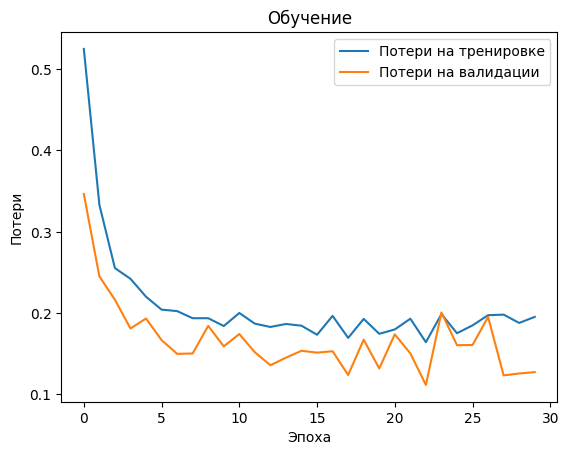

In [ ]:
plt.plot(train_losses, label = 'Потери на тренировке')
plt.plot(val_losses, label = 'Потери на валидации')
plt.title('Обучение')
plt.xlabel('Эпоха')
plt.ylabel('Потери')
plt.legend()

In [ ]:
#load weights of best model
path = 'saved_weights.pt'
model.load_state_dict(torch.load(path))

<All keys matched successfully>

In [ ]:
# Получение предсказаний для тестовых данных
with torch.no_grad():
    preds = model(test_seq.to(device), test_mask.to(device))
    preds = preds.detach().cpu().numpy()

In [ ]:
# model's performance
preds = np.argmax(preds, axis = 1)
print(classification_report(test_y, preds))

              precision    recall  f1-score   support

           0       0.99      0.98      0.98       724
           1       0.87      0.91      0.89       112

    accuracy                           0.97       836
   macro avg       0.93      0.94      0.94       836
weighted avg       0.97      0.97      0.97       836

